In [451]:
# BMED Free Running Simulator
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print("🎯 BMED Free Running Simulator")
print("📊 Interactive Parameter Testing")
print("="*60)

🎯 BMED Free Running Simulator
📊 Interactive Parameter Testing


In [ ]:
# Model Classes (same as reference)

class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

class StateExtr(nn.Module):
    """State Extractor using LayerNorm LSTM"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

class PhysicalChangeDecoder(nn.Module):
    """Physical Change Decoder"""
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

class CurrentPredictor(nn.Module):
    """Current Predictor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

✅ 모델 클래스 정의 완료


In [ ]:
class PhysicsConstraintLayer(nn.Module):
    """Physics Constraint Layer with Current Prediction and Direct ReLU Constraints"""
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        rratio = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        ratio = torch.sigmoid(rratio)
        dNALA = ratio * dNBK
        
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        # tensor 비교를 torch.where로 변경
        condition1 = VF < dVA + dVB
        dVA = torch.where(condition1, torch.zeros_like(dVA), dVA)
        dVB = torch.where(condition1, torch.zeros_like(dVB), dVB)
        
        condition2 = NFLA < dNALA
        dNALA = torch.where(condition2, torch.zeros_like(dNALA), dNALA)
        
        condition3 = NFK < dNBK
        dNBK = torch.where(condition3, torch.zeros_like(dNBK), dNBK)

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)
        
        nNFLA = NFLA - dNALA
        nNALA = NALA + dNALA
        nNFK = NFK - dNBK
        nNBK = NBK + dNBK

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        nI_pred_norm = self.current_predictor(temp_state)
        
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

class BMEDFreeRunningModel(nn.Module):
    """BMED Free Running Model for Simulation"""
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)
        
        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def free_running_forward(self, initial_state, target_length):
        batch_size = initial_state.size(0)
        feature_size = initial_state.size(1)
        device = initial_state.device
        
        self._reset_hidden_states(batch_size, device)
        
        predictions = torch.zeros(batch_size, target_length, feature_size, device=device)
        current_state = initial_state.clone()
        
        for t in range(target_length):
            predictions[:, t, :] = current_state
            
            if t < target_length - 1:
                lstm_input = current_state[:, :-1]
                hidden_output = self._forward_lstm_single_step(lstm_input)
                physical_changes = self.physical_decoder(hidden_output.unsqueeze(1))
                current_state_expanded = current_state.unsqueeze(1)
                next_state = self.physics_constraint(physical_changes, current_state_expanded)
                current_state = next_state.squeeze(1)
        
        return predictions

    def _forward_lstm_single_step(self, x_t):
        layer_input = x_t
        
        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, 
                                   (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new
            
            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new
        
        normalized = self.state_extr.final_layer_norm(layer_input)
        return self.state_extr.final_dropout(normalized)

    def forward(self, initial_state, target_length):
        return self.free_running_forward(initial_state, target_length)

✅ ReLU 기반 직접 제약이 적용된 Physics Constraint Layer 정의 완료


In [454]:
# 학습된 모델 로드
model_path = "BMED_FR_250909.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"📥 모델 파일 로드 중: {model_path}")
print(f"🔧 사용 중인 장치: {device}")

try:
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 모델 설정 정보 확인
    model_config = checkpoint['model_config']
    state_extr_params = model_config['state_extr_params']
    decoder_params = model_config['decoder_params']
    current_predictor_params = model_config['current_predictor_params']
    model_range_mm = model_config['range_mm']
    
    # 모델 생성 및 가중치 로드
    simulator_model = BMEDFreeRunningModel(
        state_extr_params=state_extr_params,
        decoder_params=decoder_params, 
        current_predictor_params=current_predictor_params,
        range_mm=model_range_mm
    ).to(device)
    
    simulator_model.load_state_dict(checkpoint['model_state_dict'])
    simulator_model.eval()
    
    print("✅ 시뮬레이터 모델 준비 완료!")
    print(f"   - 모델 성능 (Best FR Loss): {checkpoint.get('best_fr_loss', 'Unknown'):.6f}")
    
except FileNotFoundError:
    print(f"❌ 모델 파일을 찾을 수 없습니다: {model_path}")
    print("   현재 디렉토리에 BMED_FR_250817.pth 파일이 있는지 확인하세요.")
    simulator_model = None
    model_range_mm = None

📥 모델 파일 로드 중: BMED_FR_250909.pth
🔧 사용 중인 장치: cuda
✅ 시뮬레이터 모델 준비 완료!
   - 모델 성능 (Best FR Loss): 0.000911


In [455]:
# 정규화/비정규화 함수
def normalize_inputs(inputs, range_mm):
    """입력값들을 모델에서 사용하는 범위로 정규화"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    normalized = []
    
    for i, (name, value) in enumerate(zip(feature_names, inputs)):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            norm_val = (value - min_val) / (max_val - min_val)
            normalized.append(norm_val)
        else:
            normalized.append(value)
    
    return normalized

def denormalize_outputs(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

print("✅ 정규화/비정규화 함수 준비 완료")

✅ 정규화/비정규화 함수 준비 완료


In [456]:
# ========================================
# 시뮬레이션 파라미터 입력 (여기를 수정하세요)
# ========================================

# 1. 초기 상태 파라미터 (9개 입력)
V = 30.0      # Voltage (V)
E = 0.25        # External Electrolyte Concentration (M)
VF = 1.0     # Volume of Feed (L)
VA = 1.0      # Volume of Acid (L) 
VB = 2.0      # Volume of Base (L)
CFLA = 0.5   # Concentration of LA in Feed (M)
CALA = 0.0    # Concentration of LA in Acid (M)
CFK = 1.0    # Concentration of K in Feed (M)
CBK = 0.0    # Concentration of K in Base (M)

# 2. 시뮬레이션 시간 설정
simulation_time = 81  # 시뮬레이션할 시간 스텝 수

print("📋 시뮬레이션 파라미터 설정:")
print(f"   V (전압): {V} V")
print(f"   E (외부전해질질): {E}")
print(f"   VF (Feed 볼륨): {VF} L")
print(f"   VA (Acid 볼륨): {VA} L")
print(f"   VB (Base 볼륨): {VB} L")
print(f"   CFLA (Feed LA 농도): {CFLA} M")
print(f"   CALA (Acid LA 농도): {CALA} M")
print(f"   CFK (Feed K 농도): {CFK} M")
print(f"   CBK (BaseK 농도): {CBK} M")
print(f"   시뮬레이션 시간: {simulation_time} 스텝")
print("="*50)

📋 시뮬레이션 파라미터 설정:
   V (전압): 30.0 V
   E (외부전해질질): 0.25
   VF (Feed 볼륨): 1.0 L
   VA (Acid 볼륨): 1.0 L
   VB (Base 볼륨): 2.0 L
   CFLA (Feed LA 농도): 0.5 M
   CALA (Acid LA 농도): 0.0 M
   CFK (Feed K 농도): 1.0 M
   CBK (BaseK 농도): 0.0 M
   시뮬레이션 시간: 81 스텝


In [457]:
# 시뮬레이션 실행
if simulator_model is not None:
    print("🚀 Free Running 시뮬레이션 실행 중...")
    
    # 입력값 정규화 (I는 초기에 0으로 설정, 모델이 예측함)
    input_values = [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK]
    normalized_inputs = normalize_inputs(input_values, model_range_mm)
    
    # 초기 전류값 추정 (정규화된 0)
    initial_I_norm = 0.0
    
    # 초기 상태 텐서 생성 (10개 특성 모두 포함)
    initial_state_values = normalized_inputs + [initial_I_norm]
    initial_state_tensor = torch.tensor([initial_state_values]).float().to(device)
    
    # Free Running 시뮬레이션 실행
    with torch.no_grad():
        predictions = simulator_model(initial_state_tensor, simulation_time)
    
    # 결과를 numpy로 변환
    pred_normalized = predictions.cpu().numpy()  # [1, time_steps, 10]
    
    # 비정규화하여 실제 물리적 값으로 변환
    pred_physical = denormalize_outputs(pred_normalized, model_range_mm)
    
    # 시간 배열 생성
    time_steps = np.arange(simulation_time)
    
    print(f"✅ 시뮬레이션 완료! ({simulation_time} 시간 스텝)")
    
    # 결과 데이터 저장
    simulation_results = {
        'time': time_steps,
        'V': pred_physical[0, :, 0],
        'E': pred_physical[0, :, 1], 
        'VF': pred_physical[0, :, 2],
        'VA': pred_physical[0, :, 3],
        'VB': pred_physical[0, :, 4],
        'CFLA': pred_physical[0, :, 5],
        'CALA': pred_physical[0, :, 6],
        'CFK': pred_physical[0, :, 7],
        'CBK': pred_physical[0, :, 8],
        'I': pred_physical[0, :, 9]
    }
    
else:
    print("❌ 모델이 로드되지 않아 시뮬레이션을 실행할 수 없습니다.")

🚀 Free Running 시뮬레이션 실행 중...


✅ 시뮬레이션 완료! (81 시간 스텝)


In [458]:
# 시뮬레이션 결과 요약
if 'simulation_results' in locals():
    print("📋 시뮬레이션 결과 요약")
    print("="*60)
    
    print(f"🎯 시뮬레이션 설정:")
    print(f"   - 초기 전압 (V): {V} V")
    print(f"   - 초기 전기장 (E): {E}")
    print(f"   - 시뮬레이션 길이: {simulation_time} 시간 스텝")
    
    print(f"\n📊 주요 변화량:")
    for feature in ['VF', 'VA', 'VB', 'I']:
        initial = simulation_results[feature][0]
        final = simulation_results[feature][-1]
        change = final - initial
        change_pct = (change / initial * 100) if initial != 0 else 0
        print(f"   {feature:>3}: {initial:8.2f} → {final:8.2f} ({change:+8.2f}, {change_pct:+6.1f}%)")
    
    print(f"\n🧪 농도 변화:")
    for feature in ['CFLA', 'CALA', 'CFK', 'CBK']:
        initial = simulation_results[feature][0]
        final = simulation_results[feature][-1]
        change = final - initial
        change_pct = (change / initial * 100) if initial != 0 else 0
        print(f"   {feature:>4}: {initial:8.2f} → {final:8.2f} ({change:+8.2f}, {change_pct:+6.1f}%)")
    
    # 볼륨 보존 확인
    total_volume_initial = simulation_results['VF'][0] + simulation_results['VA'][0] + simulation_results['VB'][0]
    total_volume_final = simulation_results['VF'][-1] + simulation_results['VA'][-1] + simulation_results['VB'][-1]
    volume_change = total_volume_final - total_volume_initial
    
    print(f"\n⚖️  볼륨 보존 확인:")
    print(f"   초기 총 볼륨: {total_volume_initial:.2f} μL")
    print(f"   최종 총 볼륨: {total_volume_final:.2f} μL")
    print(f"   볼륨 변화: {volume_change:+.4f} μL ({volume_change/total_volume_initial*100:+.3f}%)")
    
    # 최종 전류값
    final_current = simulation_results['I'][-1]
    print(f"\n⚡ 최종 전류: {final_current:.2f} μA")
    
    print("\n" + "="*60)
    print("✅ BMED Free Running 시뮬레이션 완료!")
    print("💡 다른 파라미터로 시뮬레이션하려면 '시뮬레이션 파라미터 입력' 셀을 수정하고 다시 실행하세요.")
    
else:
    print("❌ 시뮬레이션 결과가 없습니다.")

📋 시뮬레이션 결과 요약
🎯 시뮬레이션 설정:
   - 초기 전압 (V): 30.0 V
   - 초기 전기장 (E): 0.25
   - 시뮬레이션 길이: 81 시간 스텝

📊 주요 변화량:
    VF:     1.00 →     0.91 (   -0.09,   -8.6%)
    VA:     1.00 →     0.96 (   -0.04,   -3.8%)
    VB:     2.00 →     2.12 (   +0.12,   +6.2%)
     I:     0.00 →     0.77 (   +0.77,   +0.0%)

🧪 농도 변화:
   CFLA:     0.50 →     0.00 (   -0.50,  -99.9%)
   CALA:     0.00 →     0.52 (   +0.52,   +0.0%)
    CFK:     1.00 →     0.00 (   -1.00,  -99.9%)
    CBK:     0.00 →     0.47 (   +0.47,   +0.0%)

⚖️  볼륨 보존 확인:
   초기 총 볼륨: 4.00 μL
   최종 총 볼륨: 4.00 μL
   볼륨 변화: -0.0000 μL (-0.000%)

⚡ 최종 전류: 0.77 μA

✅ BMED Free Running 시뮬레이션 완료!
💡 다른 파라미터로 시뮬레이션하려면 '시뮬레이션 파라미터 입력' 셀을 수정하고 다시 실행하세요.


In [459]:
import numpy as np
time = simulation_results['time'] * 0.25 # hr
VF = simulation_results['VF'] # L
VA = simulation_results['VA'] # L
VB = simulation_results['VB'] # L
CFLA = simulation_results['CFLA'] # mol/L
CALA = simulation_results['CALA'] # mol/L
CFK = simulation_results['CFK'] # mol/L
CBK = simulation_results['CBK'] # mol/L
I = simulation_results['I'] # A
NALA = CALA *VA # mol
MwLA=90.1 #g/mol
Amem = 0.055 #m2
flux_mol = np.zeros_like(NALA) # mol/hr
flux_mol[0] = (NALA[1] - NALA[0]) / (time[1] - time[0])
flux_mol[1:-1] = (NALA[2:] - NALA[:-2]) / (time[2:] - time[:-2])
flux_mol[-1] = (NALA[-1] - NALA[-2]) / (time[-1] - time[-2])
flux_mol = flux_mol/3600 # mol/s
JLA = flux_mol*MwLA/Amem # g/m2/s
CE = 96485*flux_mol/10/I*100 # %
SEC = V*I/(MwLA*flux_mol*3600) # kwh/kg
SEC = np.where(SEC < 0, 0, SEC)

/tmp/ipykernel_6439/1601196539.py:20: RuntimeWarning: divide by zero encountered in divide
  CE = 96485*flux_mol/10/I*100 # %
/tmp/ipykernel_6439/1601196539.py:21: RuntimeWarning: divide by zero encountered in divide
  SEC = V*I/(MwLA*flux_mol*3600) # kwh/kg


In [460]:
flux_mol

array([-1.5410990e-07,  2.5524623e-06,  7.7544519e-06,  1.1842662e-05,
        1.4423101e-05,  1.6135817e-05,  1.7550266e-05,  1.9163395e-05,
        2.1395505e-05,  2.4386702e-05,  2.7672637e-05,  3.0833078e-05,
        3.5774534e-05,  4.2578667e-05,  4.7976773e-05,  4.8832084e-05,
        4.5605568e-05,  4.2653232e-05,  3.8126956e-05,  3.1332209e-05,
        1.4107575e-05,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -1.6556846e-11,  1.6556846e-11,  3.3113692e-11,  0.0000000e+00,
       -3.3113692e-11,  0.0000000e+00,  3.3113692e-11, -1.6556846e-11,
       -1.6556846e-11,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -1.6556846e-11, -1.6556846e-11,  1.6556846e-11,  1.6556846e-11,
       -1.6556846e-11,  0.0000000e+00,  1.6556846e-11,  0.0000000e+00,
        0.0000000e+00, -1.6556846e-11,  7.1241957e-06,  7.1242121e-06,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.6556846e-11,
        0.0000000e+00,  1.6556846e-11,  0.0000000e+00,  0.0000000e+00,
      

In [461]:
end_point = 0
for i in range(len(flux_mol)-1):
    if i>4 and flux_mol[i+1] <= 1e-7:
        end_point = i
        break
print(end_point)

20


In [462]:
time2 = time[:end_point]
VF2 = VF[:end_point]
VA2 = VA[:end_point]
VB2 = VB[:end_point]
CFLA2 = CFLA[:end_point]
CALA2 = CALA[:end_point]
CFK2 = CFK[:end_point]
CBK2 = CBK[:end_point]
I2 = I[:end_point]
NALA2 = NALA[:end_point]
JLA2 = JLA[:end_point]
SEC2 = SEC[:end_point]
res = {
    'time': time2,
    'VF': VF2,
    'VA': VA2,
    'VB': VB2,
    'CFLA': CFLA2,
    'CALA': CALA2,
    'CFK': CFK2,
    'CBK': CBK2,
    'I': I2,
    'NALA': NALA2,
    'JLA': JLA2,
    'SEC': SEC2,
}

In [463]:
flux_mol

array([-1.5410990e-07,  2.5524623e-06,  7.7544519e-06,  1.1842662e-05,
        1.4423101e-05,  1.6135817e-05,  1.7550266e-05,  1.9163395e-05,
        2.1395505e-05,  2.4386702e-05,  2.7672637e-05,  3.0833078e-05,
        3.5774534e-05,  4.2578667e-05,  4.7976773e-05,  4.8832084e-05,
        4.5605568e-05,  4.2653232e-05,  3.8126956e-05,  3.1332209e-05,
        1.4107575e-05,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -1.6556846e-11,  1.6556846e-11,  3.3113692e-11,  0.0000000e+00,
       -3.3113692e-11,  0.0000000e+00,  3.3113692e-11, -1.6556846e-11,
       -1.6556846e-11,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -1.6556846e-11, -1.6556846e-11,  1.6556846e-11,  1.6556846e-11,
       -1.6556846e-11,  0.0000000e+00,  1.6556846e-11,  0.0000000e+00,
        0.0000000e+00, -1.6556846e-11,  7.1241957e-06,  7.1242121e-06,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.6556846e-11,
        0.0000000e+00,  1.6556846e-11,  0.0000000e+00,  0.0000000e+00,
      

📊 시뮬레이션 결과 시각화


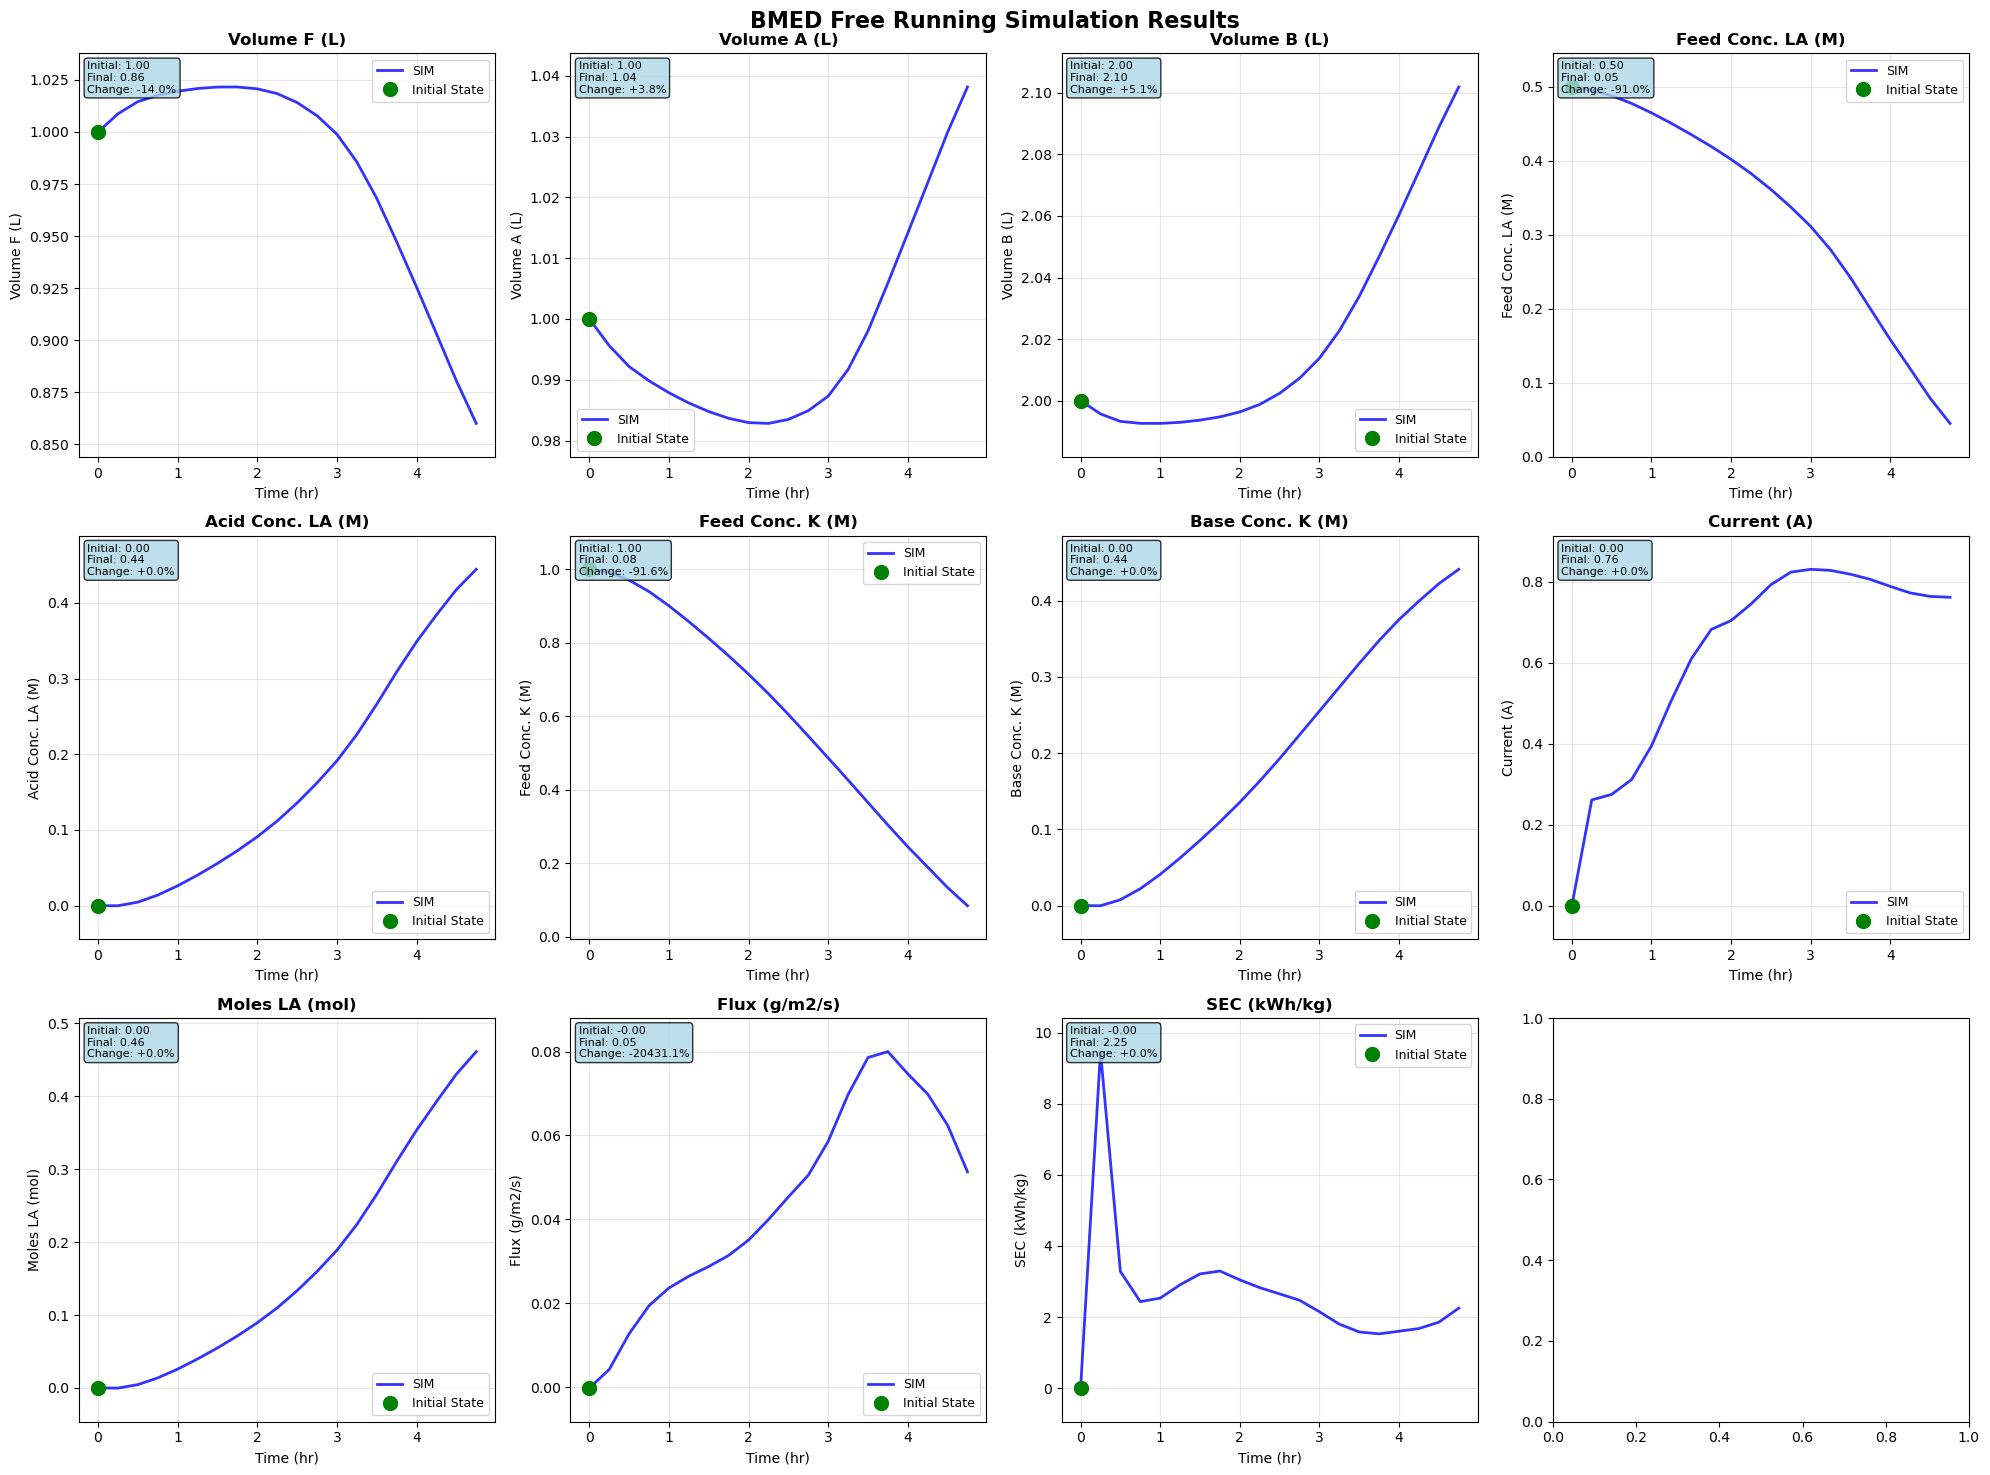

✅ 시뮬레이션 결과 시각화 완료!


In [464]:
# 시뮬레이션 결과 시각화
print("📊 시뮬레이션 결과 시각화")
print('='*50)

# 출력 features
features_to_plot = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I', 'NALA', 'JLA', 'SEC']
feature_units = {
    'VF': 'Volume F (L)',
    'VA': 'Volume A (L)',
    'VB': 'Volume B (L)',
    'CFLA': 'Feed Conc. LA (M)',
    'CALA': 'Acid Conc. LA (M)',
    'CFK': 'Feed Conc. K (M)',
    'CBK': 'Base Conc. K (M)',
    'I': 'Current (A)',
    'NALA': 'Moles LA (mol)',
    'JLA': 'Flux (g/m2/s)',
    'CE': 'CE (%)',
    'SEC': 'SEC (kWh/kg)',
}

# subplot 생성 
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('BMED Free Running Simulation Results', fontsize=16, fontweight='bold')

# generate graph for each feature
for i, feature in enumerate(features_to_plot):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    ax.plot(res['time'], res[feature],'b-', linewidth=2, label ='SIM', alpha=0.8)
    ax.plot(res['time'][0], res[feature][0], 'go', markersize=10, label='Initial State')

    ax.set_title(f'{feature_units[feature]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (hr)', fontsize=10)
    ax.set_ylabel(feature_units[feature], fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

    y_values = res[feature]
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    if y_range > 0:
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

    # text for initial and final value
    init_val = y_values[0]
    final_val = y_values[-1]
    change_pct = ((final_val - init_val) / init_val * 100) if init_val != 0 else 0

    textstr = f'Initial: {init_val:.2f}\nFinal: {final_val:.2f}\nChange: {change_pct:+.1f}%'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
plt.tight_layout()
plt.show()

print("✅ 시뮬레이션 결과 시각화 완료!")